In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from imblearn.over_sampling import SMOTE, ADASYN

from sklearn import metrics
#from sklearn.metrics import confusion_matrix
#sfrom sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

from sklearn.utils.multiclass import unique_labels

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [4]:
def printTree(feature_cols,tree):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True, feature_names = feature_cols,class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('magic_tree.png')
    Image(graph.create_png())

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [6]:
def calcMetrics(Yt, Yp, classes, model, norm=True, cols=None, print_metrics=False):
    # Metrics
    acc = metrics.accuracy_score(Yt, Yp)
    acc_bal = metrics.balanced_accuracy_score(Yt, Yp)
    prec = metrics.precision_score(Yt, Yp)
    recall = metrics.recall_score(Yt, Yp)
    f1 = metrics.f1_score(Yt, Yp)
    
    feature_imp = pd.Series(model.feature_importances_,index=cols).sort_values(ascending=True)
    
    if(print_metrics):
        print("")
        plot_confusion_matrix(Yt, Yp, classes, normalize=norm)
        print("")
        print("Accuracy:", acc)
        print("Balanced Accuracy: ", acc_bal)
        print("Precision: ", prec)
        print("Recall: ", recall)
        print("F1 Score: ", f1)
       
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.barh(feature_imp.index,feature_imp.values, align='center')
        ax.set_xlabel('Performance')
        ax.set_title('How fast do you want to go today?')
        plt.grid(True)
        
        plt.show()
    
    return acc, acc_bal, prec, recall, f1, feature_imp
    
    

In [7]:
def trainDecisionTree(Xtr, Xte, Ytr, Yte, feat_cols, print_metrics=False):
    tree = DecisionTreeClassifier()
    tree = tree.fit(Xtr,Ytr)
    yt_pred = tree.predict(Xte)
    
    return calcMetrics(Yte, yt_pred, [0,1], tree, norm=True, cols=feat_cols, print_metrics=print_metrics)


def trainRandomForest(Xtr, Xte, Ytr, Yte, feat_cols, print_metrics=False):
    forest=RandomForestClassifier(n_estimators=100)
    forest.fit(Xtr,Ytr)
    yf_pred=forest.predict(Xte)
    
    return calcMetrics(Yte, yf_pred, [0,1], forest, norm=True, cols=feat_cols, print_metrics=print_metrics)


In [8]:
feature_files = [
    "features/features_none_sre.csv",
    "features/features_div_sre.csv",
    "features/features_sub_sre.csv",
    "features/features_none_srl.csv",
    "features/features_div_srl.csv",
    "features/features_sub_srl.csv",
]

feature_cols = [
        #'duration',
        #'show_order',
        'fix_freq','sacc_freq','sr_fix_freq','sr_sacc_freq',
        'pupil_diam_right_mean','pupil_diam_right_std','pupil_diam_right_min','pupil_diam_right_max',
        'pupil_diam_left_mean','pupil_diam_left_std','pupil_diam_left_min','pupil_diam_left_max',
        'sr_pupil_diam_right_mean','sr_pupil_diam_right_std','sr_pupil_diam_right_min','sr_pupil_diam_right_max',
        'sr_pupil_diam_left_mean','sr_pupil_diam_left_std','sr_pupil_diam_left_min','sr_pupil_diam_left_max'
    ]

metrics_out = "tree_forest_metrics.csv"
metrics_out_imbal = "tree_forest_metrics_imbal.csv"


In [11]:
metrics_cols = ['filename','baseline','short_response','model', 
                                'accuracy', 'bal_accuracy', 'precision', 'recall', 'f1_score']
mDF = pd.DataFrame(columns=metrics_cols)

for file in feature_files:
    print("Process File: {}".format(file))
    
    f = file.split('/')[-1]
    mode = file.split('/')[-1].split('.')[0].split('_')
    
    tree_row = [f, mode[1], mode[2], "tree"]
    forest_row = [f, mode[1], mode[2], "forest"] 
    
    # Load the file
    features = pd.read_csv(file, sep='\t')
    features = features.fillna(0)
    
    # Extract Feature Columns
    X = features[feature_cols]
    y = features['label']
    
    # Rebalance the dataset with SMOTE
    #X, y = SMOTE().fit_resample(X, y)
    
    # Create Folds for KFold Cross Validation
    # 102 for leave one out
    splitter = KFold(n_splits=102, random_state=11)
    #splitter = LeaveOneOut()
    
    # Initialize Metrics accumulators
    t_accuracy = []
    t_bal_accuracy = []
    t_precision = []
    t_recall = []
    t_f1_score = []
    
    f_accuracy = []
    f_bal_accuracy = []
    f_precision = []
    f_recall = []
    f_f1_score = []

    
    for train_index, test_index in splitter.split(X):
        #print("train index: ", train_index)
        
        # Generate Train and Test set
        X_train = X.iloc[train_index]        
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        
        # Require if SMOTE outside
        #X_train = X[train_index]        
        #y_train = y[train_index]
        #X_test = X[test_index]
        #y_test = y[test_index]
        
        # Smothe inside the fold
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        
        # Train Decision Tree
        t_acc, t_bal, t_prec, t_rec, t_f1, t_best_feat = trainDecisionTree(X_train, X_test, y_train, y_test, feature_cols)
        t_accuracy.append(t_acc)
        t_bal_accuracy.append(t_bal)
        t_precision.append(t_prec)
        t_recall.append(t_rec)
        t_f1_score.append(t_f1)   
        
        # Train Random Forest
        f_acc, f_bal, f_prec, f_rec, f_f1, f_best_feat = trainRandomForest(X_train, X_test, y_train, y_test, feature_cols)
        f_accuracy.append(f_acc)
        f_bal_accuracy.append(f_bal)
        f_precision.append(f_prec)
        f_recall.append(f_rec)
        f_f1_score.append(f_f1)
        
    # Calculate KFold Mean results
    tree_row.append(np.mean(t_accuracy))    
    tree_row.append(np.mean(t_bal_accuracy))  
    tree_row.append(np.mean(t_precision))  
    tree_row.append(np.mean(t_recall))  
    tree_row.append(np.mean(t_f1_score))
    
    forest_row.append(np.mean(f_accuracy))    
    forest_row.append(np.mean(f_bal_accuracy))  
    forest_row.append(np.mean(f_precision))  
    forest_row.append(np.mean(f_recall))  
    forest_row.append(np.mean(f_f1_score))
    
    tree_series = pd.Series(tree_row, index=metrics_cols)
    forest_series = pd.Series(forest_row, index=metrics_cols)
   
    mDF = mDF.append(tree_series, ignore_index=True)
    mDF = mDF.append(forest_series, ignore_index=True)


#mDF.to_csv(metrics_out)    
idx = mDF[['accuracy', 'bal_accuracy', 'precision', 'recall', 'f1_score']].idxmax()
print(idx)

mDF


Process File: features/features_none_sre.csv


/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-def

KeyboardInterrupt: 

In [9]:
# SMOTE OUTSIDE features_div_sre.csv 	div 	sre 	forest 	0.889583 	0.903869 	0.875833 	0.907024 	0.879166
# NO SMOTE features_none_srl.csv 	none 	srl 	tree 	0.676471 	0.520464 	0.122222 	0.259259 	0.136508
# SMOTE INSIDE LOO 9 	features_div_srl.csv 	div 	srl 	forest 	0.745098 	0.745098 	0.019608 	0.019608 	0.019608
# SMOTE INSIDE LOO 10 	features_sub_srl.csv 	sub 	srl 	tree 	0.666667 	0.666667 	0.049020 	0.049020 	0.049020
# SMOTE IN K10 6 	features_none_srl.csv 	none 	srl 	tree 	0.599091 	0.564569 	0.189286 	0.275000 	0.188810
# SMOTE IN K10 7 	features_none_srl.csv 	none 	srl 	forest 	0.695455 	0.577175 	0.183333 	0.133333 	0.146667


#WIThOUT SR COLUMNS
# 10 	features_sub_srl.csv 	sub 	srl 	tree 	0.725455 	0.685512 	0.233333 	0.333333 	0.263333


Normalized confusion matrix
[[0.68965517 0.31034483]
 [0.10714286 0.89285714]]

Accuracy: 0.7894736842105263
Balanced Accuracy:  0.791256157635468
Precision:  0.7352941176470589
Recall:  0.8928571428571429
F1 Score:  0.806451612903226


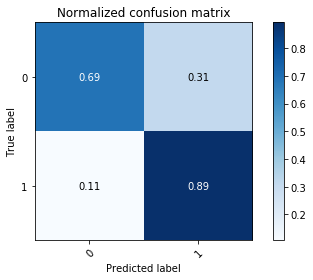

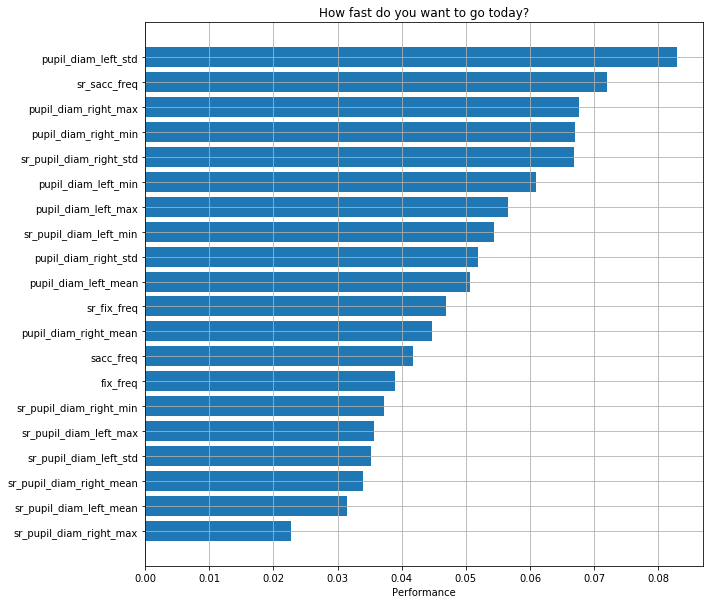

In [10]:
# Load the file
features = pd.read_csv("features/features_sub_srl.csv", sep='\t')
features = features.fillna(0)
 

# Extract Feature Columns
X = features[feature_cols]
y = features['label']
X, y = SMOTE().fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

f_acc, f_bal, f_prec, f_rec, f_f1, f_best_feat = \
    trainRandomForest(X_train, X_test, y_train, y_test, feat_cols=feature_cols, print_metrics=True)
